In [1]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_curve
import scipy.optimize as tnc
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.


# ML Pipeline Flow

In [2]:
# 1. EDA Analysis
# 2. Feature Engineering
# 3. Train-Test Split
# 4. Feature Scaling: {normalization/standardization, dimension reduction techniques, handling imbalance datasets/sampling}
# 5. Model Training -> Tuning -> Evaluating
# 6. Model Prediction
# 7. Model Deployment

In [3]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df


,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_flag
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0
...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,0
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,1
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,0
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,0


### Step 1: Data Preprocessing and Feature Engineering

In [4]:
'''Preparing the data for categorical data:
1. One-Hot Encoding: Categorical Nominal (no order/relationship) | red, green, blue => 0/1, 0/1, 0/1
2. Label Encoding: Categorical Ordinal (order/relationship/heiarchy involved) | low, medium, high => 0, 1, 2
3. Target Encoding: Categorical with many unique values to reduce dimensionality in One-Hot Encoding | Replaces category with mean of the target variable for the particular category
4. Frequency Encoding: Categorical with many unique values | Replace category with frequeny count occurance of each category
'''

# Initialize the LabelEncoder
label_enc = LabelEncoder()

# Define categorical columns excluding platform since we're using target encoding for it
categorical_cols = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'time_horizon']

# Apply Label Encoding for ordinal columns
for col in categorical_cols:
    df[col] = label_enc.fit_transform(df[col])

# Apply One-Hot Encoding for instrument_type_first_traded
df = pd.get_dummies(df, columns=['instrument_type_first_traded'], drop_first=True)

# Step 1: Calculate target encoding for the platform column
platform_target_mean = df.groupby('platform')['churn_flag'].mean()

# Step 2: Replace the platform values with target means
df['platform'] = df['platform'].map(platform_target_mean)

# Feature engineering for numerical columns
numerical_cols = ['time_spent', 'first_deposit_amount']
df['deposit_per_time'] = df['first_deposit_amount'] / (df['time_spent'] + 1)
df['is_high_risk'] = (df['risk_tolerance'] == 0).astype(int)

# Define features and target variable
X = df.drop(columns=['user_id', 'churn_flag'])
y = df['churn_flag']

# SMOTE for resampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\cheng\Workspace\robinhood_classifer\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\cheng\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\cheng\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\cheng\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 1307, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [5]:
platform_target_mean

platform
Android    0.052322
both       0.073267
iOS        0.045634
Name: churn_flag, dtype: float64

### Step 2: Model Definition and Objective Function for Optuna

In [6]:
def objective(trial):
    # **Step 1: Define the scaling options**
    scaler_options = {
        'standard': StandardScaler(),
        'minmax': MinMaxScaler(),
        'normalize': Normalizer(),
        'none': 'passthrough'  # Changed from None to 'none' for clarity
    }
    scaler = scaler_options[trial.suggest_categorical('scaler', ['standard', 'minmax', 'normalize', 'none'])]

    # **Step 2: Define feature selection options**
    feature_selection_type = trial.suggest_categorical('feature_selection', ['generic_univariate', 'rfe', 'none'])

    if feature_selection_type == 'generic_univariate':
        percentile = trial.suggest_int('percentile', 10, 50)
        feature_selector = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=percentile)
        # Estimate max possible features after selection
        pca_max = max(1, int(np.ceil(19 * percentile / 100)))  # Assuming 19 features initially
    elif feature_selection_type == 'rfe':
        n_features_to_select = trial.suggest_int('n_features_to_select', 5, 20)
        feature_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features_to_select)
        pca_max = n_features_to_select
    else:
        feature_selector = 'passthrough'
        pca_max = 19  # Original number of features

    # **Step 3: Define dimensionality reduction options**
    dim_reduction_type = trial.suggest_categorical('dim_reduction', ['pca', 'none'])

    if dim_reduction_type == 'pca':
        # Ensure pca_n_components does not exceed pca_max
        pca_n_components = trial.suggest_int('pca_n_components', 1, min(30, pca_max))
        dim_reduction = PCA(n_components=pca_n_components)
    else:
        dim_reduction = 'passthrough'

    # **Step 4: Define sampling options**
    sampling_type = trial.suggest_categorical('sampling', ['smote', 'random_oversampling', 'random_undersampling', 'none'])

    if sampling_type == 'smote':
        sampler = SMOTE(random_state=42)
    elif sampling_type == 'random_oversampling':
        sampler = RandomOverSampler(random_state=42)
    elif sampling_type == 'random_undersampling':
        sampler = RandomUnderSampler(random_state=42)
    else:
        sampler = 'passthrough'

    # **Step 5: Define model options**
    model_type = trial.suggest_categorical('model_type', ['xgboost', 'lightgbm', 'randomforest', 'logistic'])

    if model_type == 'xgboost':
        model = xgb.XGBClassifier(
            max_depth=trial.suggest_int('xgb_max_depth', 3, 10),
            learning_rate=trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('xgb_n_estimators', 50, 300),
            subsample=trial.suggest_float('xgb_subsample', 0.6, 1.0),
            use_label_encoder=False,
            eval_metric='logloss'
        )
    elif model_type == 'lightgbm':
        model = lgb.LGBMClassifier(
            num_leaves=trial.suggest_int('lgb_num_leaves', 20, 150),
            learning_rate=trial.suggest_float('lgb_learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('lgb_n_estimators', 50, 300),
            feature_fraction=trial.suggest_float('lgb_feature_fraction', 0.6, 1.0)
        )
    elif model_type == 'randomforest':
        max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2', 'None'])
        model = RandomForestClassifier(
            max_depth=trial.suggest_int('rf_max_depth', 3, 10),
            n_estimators=trial.suggest_int('rf_n_estimators', 50, 300),
            max_features=None if max_features == 'None' else max_features,
            random_state=42
        )
    else:  # Logistic Regression
        penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2'])
        model = LogisticRegression(
            penalty=penalty,
            C=trial.suggest_float('lr_C', 0.01, 10, log=True),
            solver='liblinear'
        )

    # **Step 6: Build the pipeline using imblearn's Pipeline**
    pipeline = ImbPipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('dim_reduction', dim_reduction),
        ('sampler', sampler),
        ('model', model)
    ])

    # **Step 7: Cross-validation**
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []

    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

        try:
            # Fit the pipeline on training data
            pipeline.fit(X_train, y_train)

            # Predict probabilities on validation data
            y_pred_proba = pipeline.predict_proba(X_valid)[:, 1]

            # Calculate ROC AUC
            roc_auc = roc_auc_score(y_valid, y_pred_proba)
            roc_auc_scores.append(roc_auc)
        except Exception as e:
            # If any error occurs during fitting/prediction, skip this trial
            return 0.0  # Assign a poor score to this trial

    # Return the average ROC AUC score
    return np.mean(roc_auc_scores)

### Step 3: Running Optuna for Hyperparameter Tuning

In [7]:
# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=50) #n_trials=100)

# Print the best trial and parameters
print(f"Best Trial: {study.best_trial}")
print(f"Best Parameters: {study.best_params}")

[I 2024-10-07 16:11:13,349] A new study created in memory with name: no-name-50c32b49-286f-44d1-a0ba-b0ae8433d9d1
[16:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:11:14] WARNING: C:\buildkite-agent\builds\buildkite-wi

[LightGBM] [Warning] feature_fraction is set=0.890871995039923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.890871995039923
[LightGBM] [Warning] feature_fraction is set=0.890871995039923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.890871995039923
[LightGBM] [Info] Number of positive: 4244, number of negative: 4244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2800
[LightGBM] [Info] Number of data points in the train set: 8488, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.890871995039923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.890871995039923
[LightGBM] [Warning] feature_fraction is set=0.890871995039923, colsample_bytree=1.0 will be ignored. Curren

[I 2024-10-07 16:12:32,932] Trial 6 finished with value: 0.5562602971957354 and parameters: {'scaler': 'standard', 'feature_selection': 'rfe', 'n_features_to_select': 18, 'dim_reduction': 'pca', 'pca_n_components': 11, 'sampling': 'random_oversampling', 'model_type': 'lightgbm', 'lgb_num_leaves': 28, 'lgb_learning_rate': 0.11307528571782949, 'lgb_n_estimators': 255, 'lgb_feature_fraction': 0.890871995039923}. Best is trial 4 with value: 0.6130785096147962.


[LightGBM] [Warning] feature_fraction is set=0.890871995039923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.890871995039923


[I 2024-10-07 16:12:34,548] Trial 7 finished with value: 0.5953509308787348 and parameters: {'scaler': 'normalize', 'feature_selection': 'generic_univariate', 'percentile': 31, 'dim_reduction': 'pca', 'pca_n_components': 3, 'sampling': 'smote', 'model_type': 'logistic', 'lr_penalty': 'l1', 'lr_C': 0.05670648489982168}. Best is trial 4 with value: 0.6130785096147962.
[I 2024-10-07 16:12:38,155] Trial 8 finished with value: 0.5870337038079734 and parameters: {'scaler': 'none', 'feature_selection': 'none', 'dim_reduction': 'pca', 'pca_n_components': 15, 'sampling': 'random_undersampling', 'model_type': 'randomforest', 'rf_max_features': 'None', 'rf_max_depth': 3, 'rf_n_estimators': 177}. Best is trial 4 with value: 0.6130785096147962.


[LightGBM] [Warning] feature_fraction is set=0.8670542932479086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670542932479086
[LightGBM] [Warning] feature_fraction is set=0.8670542932479086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670542932479086
[LightGBM] [Info] Number of positive: 223, number of negative: 4244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 4467, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049922 -> initscore=-2.946090
[LightGBM] [Info] Start training from score -2.946090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8670542932479086, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2024-10-07 16:12:41,139] Trial 9 finished with value: 0.5613756625090273 and parameters: {'scaler': 'standard', 'feature_selection': 'none', 'dim_reduction': 'pca', 'pca_n_components': 11, 'sampling': 'none', 'model_type': 'lightgbm', 'lgb_num_leaves': 146, 'lgb_learning_rate': 0.014103455074950606, 'lgb_n_estimators': 169, 'lgb_feature_fraction': 0.8670542932479086}. Best is trial 4 with value: 0.6130785096147962.


[LightGBM] [Warning] feature_fraction is set=0.8670542932479086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8670542932479086


[I 2024-10-07 16:13:37,447] Trial 10 finished with value: 0.5609876739659962 and parameters: {'scaler': 'none', 'feature_selection': 'rfe', 'n_features_to_select': 5, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'logistic', 'lr_penalty': 'l2', 'lr_C': 8.946588004536038}. Best is trial 4 with value: 0.6130785096147962.
[16:13:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:13:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:14:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:14:19] WARNING: C:\buildkite-agent\builds

[LightGBM] [Warning] feature_fraction is set=0.6071954217857634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6071954217857634
[LightGBM] [Warning] feature_fraction is set=0.6071954217857634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6071954217857634
[LightGBM] [Info] Number of positive: 223, number of negative: 4244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 4467, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049922 -> initscore=-2.946090
[LightGBM] [Info] Start training from score -2.946090
[LightGBM] [Warning] feature_fraction is set=0.6071954217857634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.60

[I 2024-10-07 16:17:48,469] Trial 19 finished with value: 0.5413582200080785 and parameters: {'scaler': 'minmax', 'feature_selection': 'rfe', 'n_features_to_select': 15, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'lightgbm', 'lgb_num_leaves': 92, 'lgb_learning_rate': 0.26736266386513113, 'lgb_n_estimators': 51, 'lgb_feature_fraction': 0.6071954217857634}. Best is trial 16 with value: 0.6223606129968052.


[LightGBM] [Warning] feature_fraction is set=0.6071954217857634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6071954217857634
[LightGBM] [Warning] feature_fraction is set=0.6071954217857634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6071954217857634
[LightGBM] [Info] Number of positive: 224, number of negative: 4244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 4468, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050134 -> initscore=-2.941615
[LightGBM] [Info] Start training from score -2.941615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-10-07 16:17:52,076] Trial 20 finished with value: 0.5534455365558099 and parameters: {'scaler': 'minmax', 'feature_selection': 'generic_univariate', 'percentile': 11, 'dim_reduction': 'none', 'sampling': 'smote', 'model_type': 'randomforest', 'rf_max_features': 'log2', 'rf_max_depth': 8, 'rf_n_estimators': 99}. Best is trial 16 with value: 0.6223606129968052.
[I 2024-10-07 16:18:43,188] Trial 21 finished with value: 0.6172195735461522 and parameters: {'scaler': 'standard', 'feature_selection': 'rfe', 'n_features_to_select': 9, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'randomforest', 'rf_max_features': 'None', 'rf_max_depth': 5, 'rf_n_estimators': 222}. Best is trial 16 with value: 0.6223606129968052.
[I 2024-10-07 16:19:33,436] Trial 22 finished with value: 0.6171204879004124 and parameters: {'scaler': 'standard', 'feature_selection': 'rfe', 'n_features_to_select': 9, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'randomforest', 'rf_max_features':

[LightGBM] [Warning] feature_fraction is set=0.6677897010001129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6677897010001129
[LightGBM] [Warning] feature_fraction is set=0.6677897010001129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6677897010001129
[LightGBM] [Info] Number of positive: 223, number of negative: 223
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 446, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2024-10-07 16:22:56,431] Trial 28 finished with value: 0.5635178770334284 and parameters: {'scaler': 'standard', 'feature_selection': 'generic_univariate', 'percentile': 11, 'dim_reduction': 'none', 'sampling': 'random_undersampling', 'model_type': 'lightgbm', 'lgb_num_leaves': 22, 'lgb_learning_rate': 0.010563440889404668, 'lgb_n_estimators': 299, 'lgb_feature_fraction': 0.6677897010001129}. Best is trial 16 with value: 0.6223606129968052.


[LightGBM] [Warning] feature_fraction is set=0.6677897010001129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6677897010001129
[LightGBM] [Warning] feature_fraction is set=0.6677897010001129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6677897010001129
[LightGBM] [Info] Number of positive: 224, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[16:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:23:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:24:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[16:24:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "u

[LightGBM] [Warning] feature_fraction is set=0.9902189978163063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9902189978163063
[LightGBM] [Warning] feature_fraction is set=0.9902189978163063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9902189978163063
[LightGBM] [Info] Number of positive: 223, number of negative: 4244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 4467, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049922 -> initscore=-2.946090
[LightGBM] [Info] Start training from score -2.946090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-10-07 16:28:38,793] Trial 40 finished with value: 0.5475685459686401 and parameters: {'scaler': 'standard', 'feature_selection': 'none', 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'lightgbm', 'lgb_num_leaves': 142, 'lgb_learning_rate': 0.04249045370580446, 'lgb_n_estimators': 59, 'lgb_feature_fraction': 0.9902189978163063}. Best is trial 16 with value: 0.6223606129968052.


[LightGBM] [Warning] feature_fraction is set=0.9902189978163063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9902189978163063


[I 2024-10-07 16:28:43,506] Trial 41 finished with value: 0.6170022767053871 and parameters: {'scaler': 'standard', 'feature_selection': 'generic_univariate', 'percentile': 50, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'randomforest', 'rf_max_features': 'None', 'rf_max_depth': 4, 'rf_n_estimators': 140}. Best is trial 16 with value: 0.6223606129968052.
[I 2024-10-07 16:28:48,206] Trial 42 finished with value: 0.6082357063294859 and parameters: {'scaler': 'standard', 'feature_selection': 'generic_univariate', 'percentile': 40, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'randomforest', 'rf_max_features': 'None', 'rf_max_depth': 4, 'rf_n_estimators': 158}. Best is trial 16 with value: 0.6223606129968052.
[I 2024-10-07 16:28:50,888] Trial 43 finished with value: 0.6125401789539395 and parameters: {'scaler': 'standard', 'feature_selection': 'generic_univariate', 'percentile': 21, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'randomforest', 'rf_

Best Trial: FrozenTrial(number=16, state=TrialState.COMPLETE, values=[0.6223606129968052], datetime_start=datetime.datetime(2024, 10, 7, 16, 17, 4, 703157), datetime_complete=datetime.datetime(2024, 10, 7, 16, 17, 14, 347352), params={'scaler': 'standard', 'feature_selection': 'rfe', 'n_features_to_select': 18, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'randomforest', 'rf_max_features': 'None', 'rf_max_depth': 5, 'rf_n_estimators': 69}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'scaler': CategoricalDistribution(choices=('standard', 'minmax', 'normalize', 'none')), 'feature_selection': CategoricalDistribution(choices=('generic_univariate', 'rfe', 'none')), 'n_features_to_select': IntDistribution(high=20, log=False, low=5, step=1), 'dim_reduction': CategoricalDistribution(choices=('pca', 'none')), 'sampling': CategoricalDistribution(choices=('smote', 'random_oversampling', 'random_undersampling', 'none')), 'model_type': CategoricalDistributio

### Step 4: Final Model Selection and Evaluation

In [8]:
# Extract the best parameters from the Optuna study
best_params = study.best_params

# Define the components of the pipeline based on the best parameters
pipeline_steps = []

# Step 1: Add the scaler based on best_params
scaler_options = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'normalize': Normalizer(),
    None: 'passthrough'
}
pipeline_steps.append(('scaler', scaler_options[best_params['scaler']]))

# Step 2: Add feature selection based on best_params
feature_selection_options = {
    'generic_univariate': GenericUnivariateSelect(
        score_func=mutual_info_classif,
        mode='percentile',
        param=best_params.get('percentile', 10)  # Default to 10 if 'percentile' is missing
    ),
    'rfe': RFE(
        estimator=RandomForestClassifier(),
        n_features_to_select=best_params.get('n_features_to_select', 5)  # Default to 5 if 'n_features_to_select' is missing
    ),
    None: 'passthrough'
}
pipeline_steps.append(('feature_selector', feature_selection_options[best_params['feature_selection']]))

# Step 3: Add PCA or passthrough for dimensionality reduction
def dynamic_pca_components(X):
    return min(best_params.get('pca_n_components', 1), X.shape[1])  # Default to 1 component if missing

# Adjust the PCA step to account for X_resampled shape at runtime
if best_params['dim_reduction'] == 'pca':
    pipeline_steps.append(('dim_reduction', PCA(n_components=dynamic_pca_components(X_resampled))))
else:
    pipeline_steps.append(('dim_reduction', 'passthrough'))

# Step 4: Add model based on the best model_type
if best_params['model_type'] == 'xgboost':
    best_model = xgb.XGBClassifier(
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        subsample=best_params['subsample']
    )
elif best_params['model_type'] == 'lightgbm':
    best_model = lgb.LGBMClassifier(
        num_leaves=best_params['num_leaves'],
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        feature_fraction=best_params['feature_fraction']
    )
elif best_params['model_type'] == 'randomforest':
    best_model = RandomForestClassifier(
        max_depth=best_params.get('max_depth', None), #,best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        max_features=best_params['max_features']
    )
else:
    # Use .get() with default values to avoid KeyError
    best_model = LogisticRegression(
        penalty=best_params.get('penalty', 'l2'),  # Default to 'l2' penalty if not found
        C=best_params.get('C', 1.0),  # Default to C=1.0 if not found
        solver=best_params.get('solver', 'liblinear')  # Default to 'liblinear' solver if not found
    )

# Add the model to the pipeline
pipeline_steps.append(('model', best_model))

# Build the final pipeline
pipeline = Pipeline(pipeline_steps)

# Train the pipeline on the resampled data
pipeline.fit(X_resampled, y_resampled)

# Step 5: Evaluate the pipeline on the original (non-resampled) data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Step 6: Final model performance evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Step 7: Output the results
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print final results
print(f'Final Model Accuracy: {accuracy}')
print(f'Final Model ROC AUC: {roc_auc}')
print(f'Final Model Precision-Recall AUC: {pr_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')


KeyError: 'n_estimators'

### Step 5: Model Explainability with SHAP

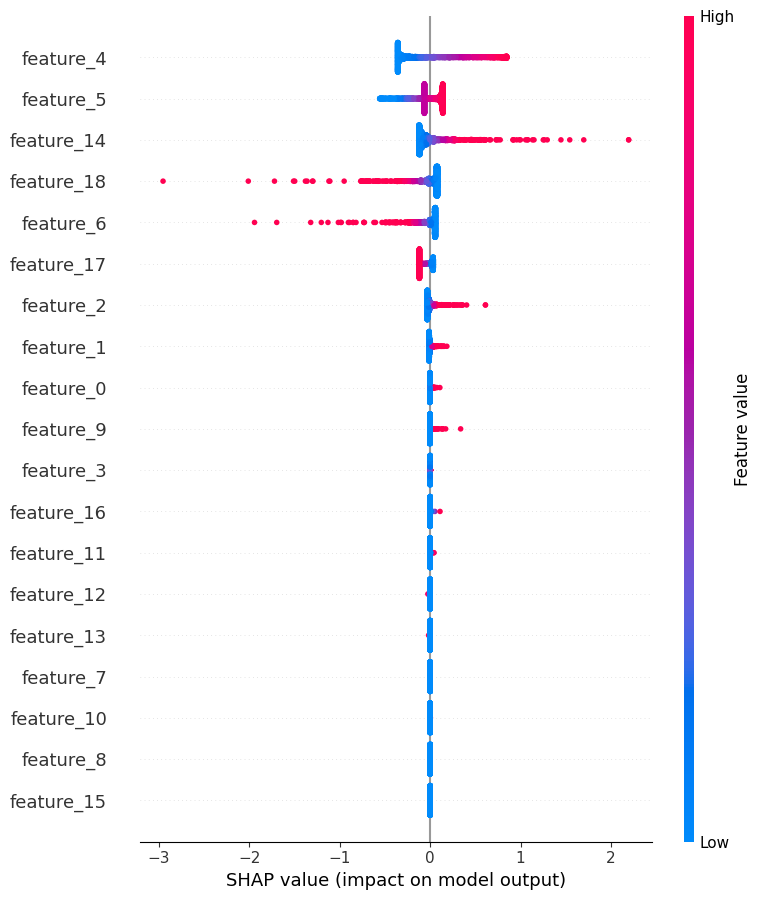

In [17]:
# Check if the best_model is tree-based
if isinstance(best_model, (RandomForestClassifier, XGBClassifier, LGBMClassifier)):
    # SHAP for tree-based models
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(pipeline[:-1].transform(X_test))  # Apply all transformations except the model
    shap.summary_plot(shap_values, pipeline[:-1].transform(X_test), feature_names=X.columns)

elif isinstance(best_model, LogisticRegression):
    # Apply all transformations except the model to X_test
    X_test_transformed = pipeline[:-1].transform(X_test)

    # Get the feature names after transformations (if available)
    transformed_feature_names = X_test_transformed.columns if hasattr(X_test_transformed, 'columns') else [f'feature_{i}' for i in range(X_test_transformed.shape[1])]

    # SHAP for logistic regression using transformed data
    explainer = shap.Explainer(best_model, X_test_transformed)

    # Calculate SHAP values
    shap_values = explainer(X_test_transformed)

    # SHAP Summary Plot with the correct feature names
    shap.summary_plot(shap_values, X_test_transformed, feature_names=transformed_feature_names)

else:
    print("Model type not supported for SHAP explainer")


# # SHAP for feature importance
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_test)

# # SHAP Summary Plot
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)


## EDA Visuals

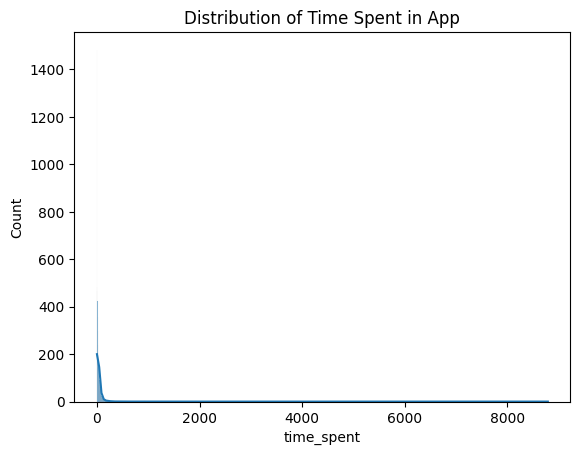

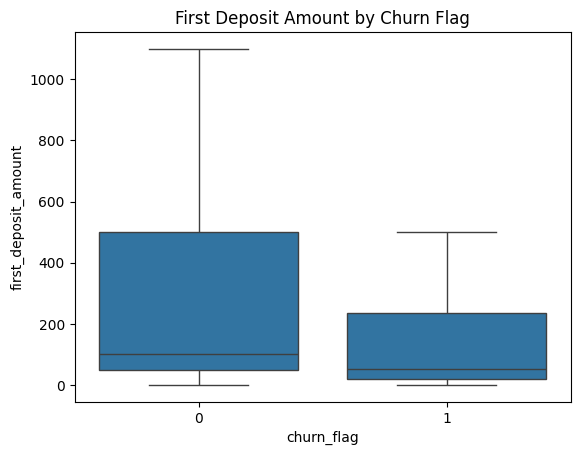

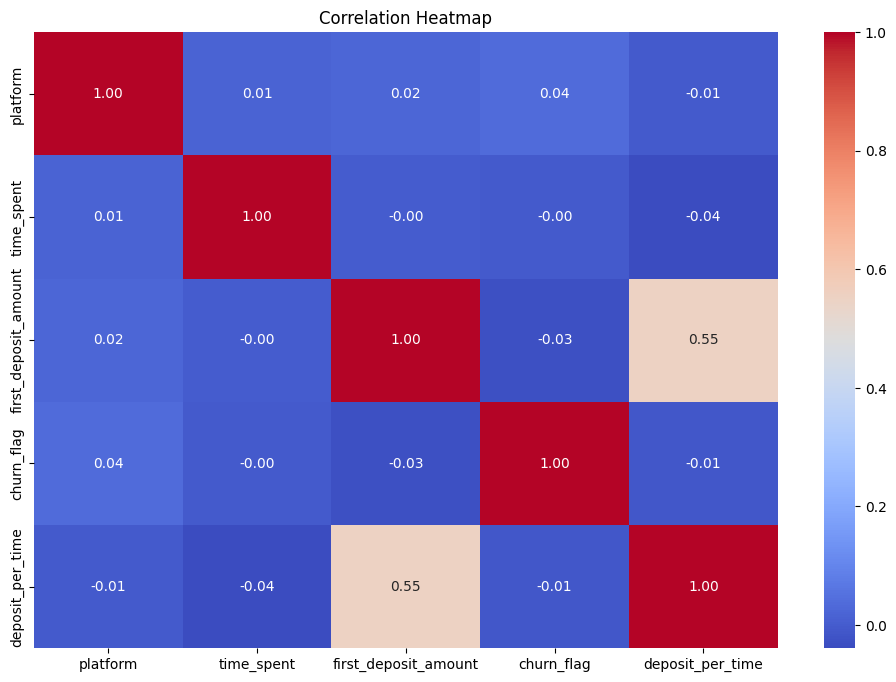

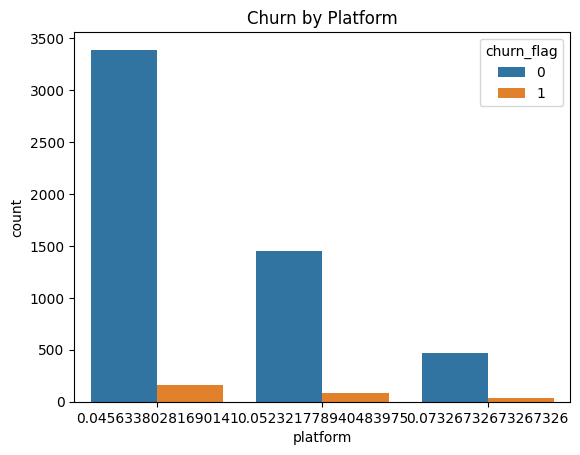

In [18]:
# Distribution of time spent in app
sns.histplot(df['time_spent'], kde=True)
plt.title('Distribution of Time Spent in App')
plt.show()

# Boxplot of first deposit amount by churn flag
sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df, showfliers=False)
plt.title('First Deposit Amount by Churn Flag')
plt.show()

# Select only the numerical columns from the DataFrame
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create the heatmap using the correlation matrix of the numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Countplot for churn by platform for categorical features
sns.countplot(x='platform', hue='churn_flag', data=df)
plt.title('Churn by Platform')
plt.show()


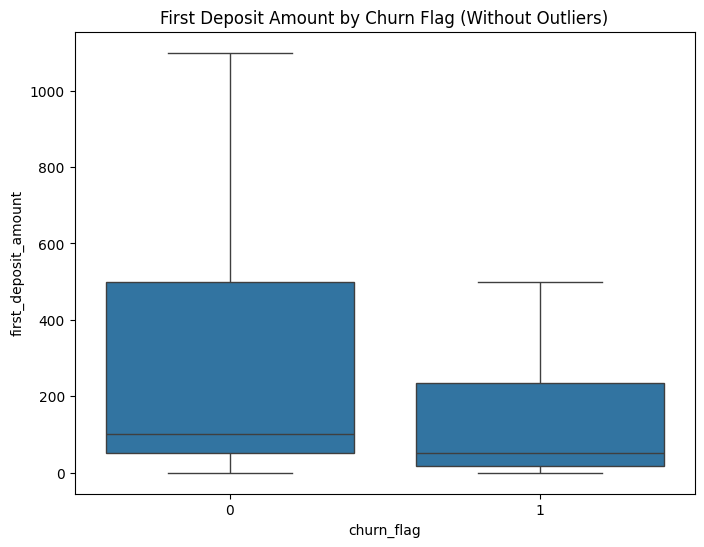

In [19]:
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df, showfliers=False)
plt.title('First Deposit Amount by Churn Flag (Without Outliers)')
plt.show()


# ENHACEMENTS: